# Булет

## Референци

- [Bullet3](https://github.com/bulletphysics/bullet3)
- [Документација за Bullet](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit?usp=sharing)

## Упатство за инсталирање
```bash
mamba install pybullet
```

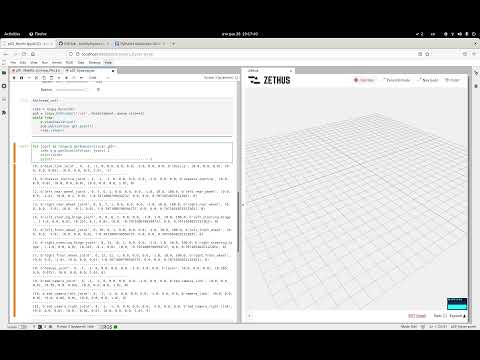

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('5dgXxiu4P-U')

In [2]:
import time
import numpy as np
import ipywidgets as ipw

In [3]:
import pybullet_data
import pybullet as p

pybullet build time: Dec 10 2021 09:49:03


### Упатство како да отпочнете Булет сервер

- Пробај прво со `p.connect(p.GUI)`. Треба да се рендерира симулацијата во нов прозорец.
- За да го искучиш рендерирањето, замени го `p.GUI` со `p.DIRECT`. Сега го немаш прозорецот.
- Кај мене оди споро рендерирањето со пајтон 3.8 (jupyros работи само со 3.8), а во ред работи на пајтон 3.10. Привременото решение кое го преземам е:
    1. Вклучува конда околина со пајтон 3.10 каде рендерирање е во ред. Таму користам `p.GUI_SERVER`.
    2. Од тетратката со пајтон 3.8 се поврзувам преку `p.SHARED_MEMORY`.

In [4]:
p.connect(p.SHARED_MEMORY)

0

In [5]:
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [6]:
import rospy
import jupyros
from geometry_msgs.msg import PoseStamped, Point, Quaternion
import tf.transformations as tft

In [7]:
rospy.init_node('CarNode')

In [8]:
class Car:
    def __init__(self, **kwargs):
        self.bid = p.loadURDF('racecar/racecar.urdf', **kwargs)
    
    def set_velocity(self, velocity, force=10):
        for wheel in [2, 3, 5, 7]:
            p.setJointMotorControl2(
                self.bid, wheel, p.VELOCITY_CONTROL, 
                targetVelocity=velocity, force=force)
    
    def set_steering(self, angle):
        for hinge in [4, 6]: 
            p.setJointMotorControl2(
                self.bid, hinge, p.POSITION_CONTROL, targetPosition=angle)
    
    def get_bt_pose(self):
        return p.getBasePositionAndOrientation(self.bid)
    
    def get_msg_pose(self):
        ps = PoseStamped()
        ps.header.stamp = rospy.Time.now()
        ps.header.frame_id = 'Car'
        position, orientation = self.get_bt_pose()
        ps.pose.position = Point(*position)
        ps.pose.orientation = Quaternion(*orientation)
        return ps
    
    def get_depth(self, range_of_sensor=3):
        loc, quat = self.get_bt_pose()
        q_inv = tft.quaternion_inverse(quat)
        q_loc_sensor_local = np.array([0.4, 0, 0.05, 0])
        q_temp = tft.quaternion_multiply(quat, q_loc_sensor_local)
        loc_sensor = loc + tft.quaternion_multiply(q_temp, q_inv)[:3]
        q_loc_sensor_local = q_loc_sensor_local
        q_loc_range_local = q_loc_sensor_local.copy()
        q_loc_range_local[0] += range_of_sensor
        q_temp = tft.quaternion_multiply(quat, q_loc_range_local)
        loc_range = loc + tft.quaternion_multiply(q_temp, q_inv)[:3]
        ray_test = p.rayTest(loc_sensor, loc_range)
        fraction = ray_test[0][2]
        return fraction * range_of_sensor

In [9]:
def init_world():
    p.resetSimulation()
    p.setGravity(0, 0, -10)
    p.setRealTimeSimulation(False)
    plane = p.loadURDF('plane.urdf')
    car = Car(basePosition=[1, 1, 0])
    cube = p.loadURDF('cube.urdf', basePosition=[2, 2, 1])
    return car

car = init_world()

In [10]:
def cb_steering(change):
    car.set_steering(-change.new)

wd_steering = ipw.FloatSlider(
    value=0, min=-0.5, max=0.5, step=0.05, continuous_update=True, 
    description='Волан:')
wd_steering.observe(cb_steering, names='value')


def cb_velocity(change):
    car.set_velocity(change.new)

wd_velocity = ipw.IntSlider(
    value=0, min=-10, max=30, step=1, continuous_update=True, 
    description='Брзина:')
wd_velocity.observe(cb_velocity, names='value')

ipw.VBox([wd_steering, wd_velocity])

In [11]:
%%thread_cell

rate = rospy.Rate(60)
pub = rospy.Publisher('/car', PoseStamped, queue_size=10)
while True:
    p.stepSimulation()
    pub.publish(car.get_msg_pose())
    rate.sleep()

Output(layout=Layout(border='1px solid gray'))

In [12]:
car.get_depth()

3.0

In [ ]:
for joint in range(p.getNumJoints(car.bid)):
    info = p.getJointInfo(car.bid, joint)
    print(info)
    print('------------------------------------------------')